In [1]:
%matplotlib notebook

%config Completer.use_jedi = False

In [2]:
from pathlib import Path

import sys
sys.path.insert(0,"/Users/danakoeppe/PipelineProjects/SAMOS_DRP/SAMOS_Draft/")

import os

In [3]:
import ccdproc as ccdp
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import LogNorm
from PIPELINE.convenience_functions import show_image

from astropy.utils.data import get_pkg_data_filename
from astropy.table import Table
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import importlib
import collections


import cmocean.cm as cm

import ccdproc


from itertools import groupby

from PIL import Image as P

#general os
import os
import zipfile
import urllib.request

#general plotting
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

params={'legend.fontsize':'18','axes.labelsize':'18',
        'axes.titlesize':'18','xtick.labelsize':'18',
        'ytick.labelsize':'18','lines.linewidth':2,'axes.linewidth':2,'animation.html': 'html5'}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})

#table/math handling
import pandas as pd
import numpy as np
np.seterr(all='ignore')  # hides irrelevant warnings about divide-by-zero, etc

#astropy
import astropy
import astropy.units as u
from astropy.table import QTable
from astropy.io import fits,ascii
from astropy.nddata import StdDevUncertainty
from astropy.modeling import models, fitting
from astropy.visualization import quantity_support,astropy_mpl_style, simple_norm
from astropy import constants as const
from astropy.stats import mad_std, sigma_clip
from astropy.nddata import CCDData
from astropy.visualization import hist
from PIPELINE.convenience_functions import show_image, display_cosmic_rays

#specutils
import specutils
from specutils import Spectrum1D, SpectralRegion
from specutils.manipulation import gaussian_smooth
from specutils.fitting import fit_generic_continuum
from specutils.fitting import find_lines_derivative
from specutils.fitting import find_lines_threshold
from specutils.fitting import fit_lines
from specutils.manipulation import noise_region_uncertainty
from specutils.analysis import centroid
from specutils.analysis import line_flux
from specutils.analysis import equivalent_width
from specutils.analysis import template_comparison

quantity_support();  # auto-recognizes units on matplotlib plots

from ipywidgets import interact
import ipywidgets as widgets

<IPython.core.display.Javascript object>


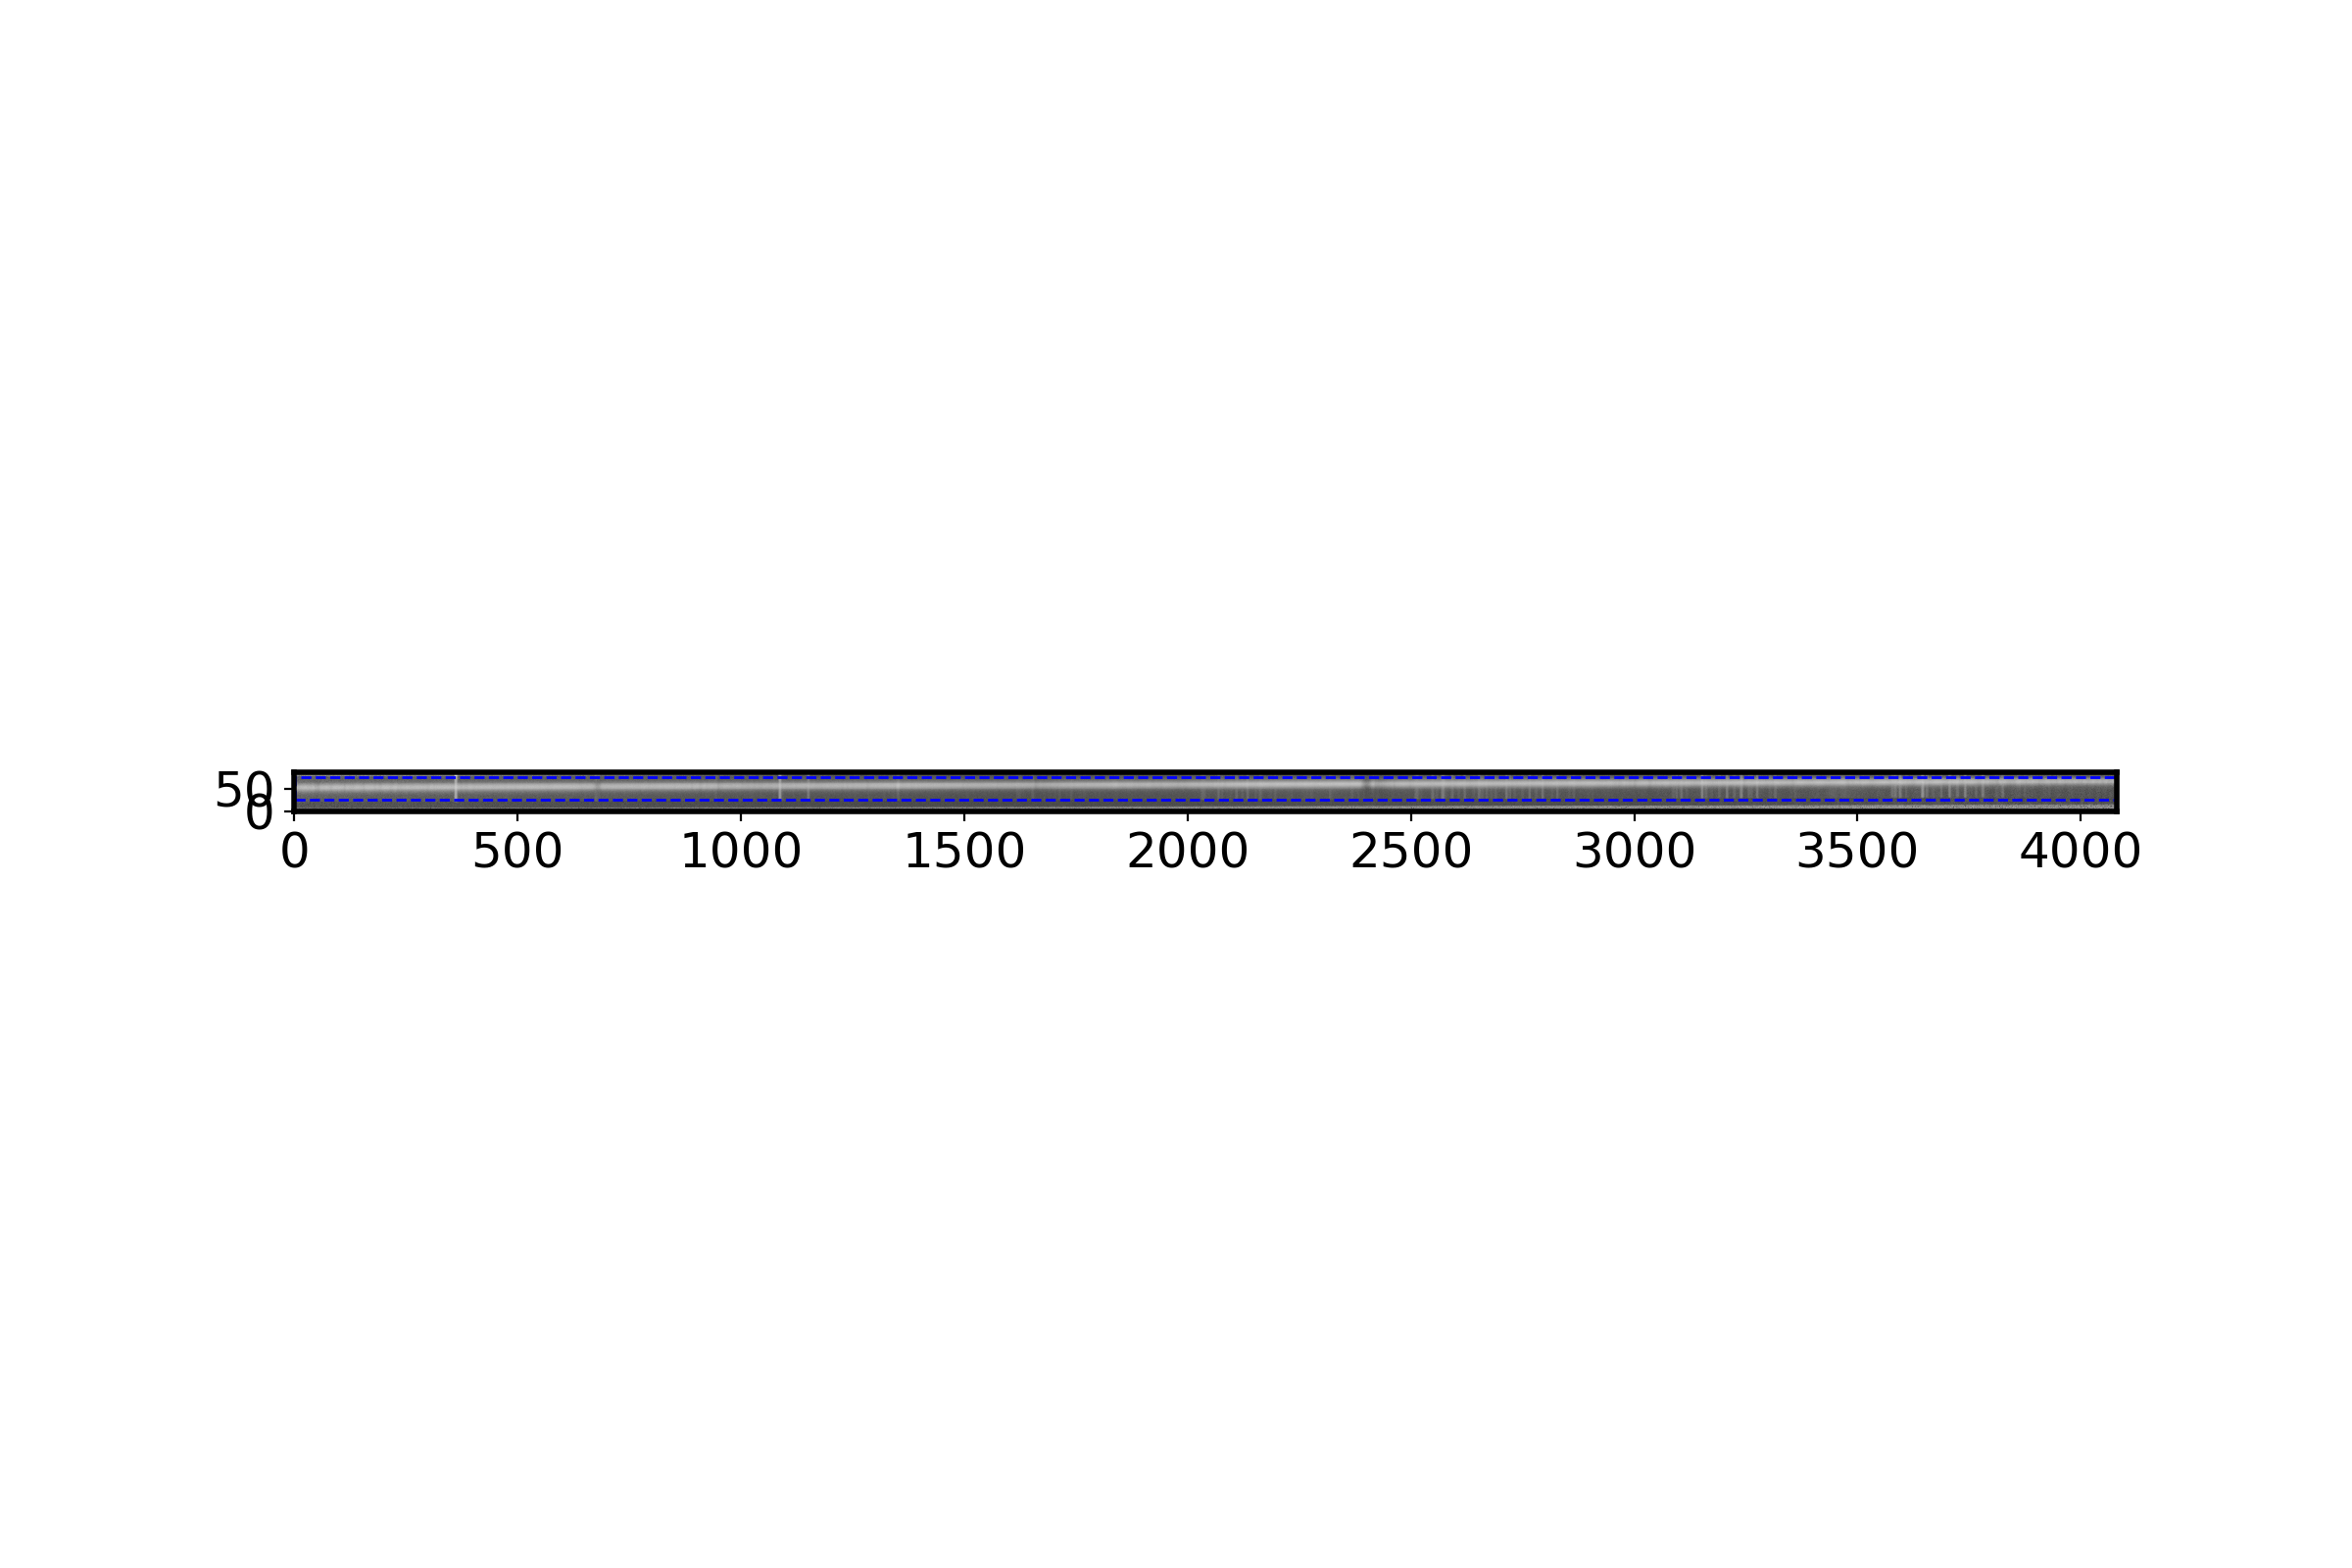

In [35]:


ccd = CCDData.read("processed/Ori0B1-field2-0000R/s_ftz_combined_orionfield-2_400_01-2-0000_13.fits",hdu=3)





fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()

norm = simple_norm(ccd, stretch='log')

slice_width = 15
initial_column = 1 #ccd.shape[1] // 2



sx, sy,  = initial_column, 25

sw, sh = ccd.shape[1]-sx, ccd.shape[0]-sy-10
    #starting col, starting row, slice width, slice height
    #slice_rectangle = Rectangle((sx, sy), sw, sh, facecolor='none', edgecolor='cyan', linestyle='--',lw=1.)

x,y = sx, sy    #slice_rectangle.xy
w = sw          #slice_rectangle.get_width() 
h = sh          #slice_rectangle.get_height() 


er_y, er_x = np.mgrid[y:y+h, x:x+w]

#print(er_y,er_x,ccd.shape,w,h)
extraction_region = ccd.data[er_y, er_x]
er_ny, er_nx = extraction_region.shape


region_x,region_y = sx, sy
region_h, region_w = sh, sw
region_rectangle = Rectangle((region_x, region_y), region_w, region_h, 
                             facecolor='none', edgecolor='b', linestyle='--')

aspect_ratio = er_nx / (3. * er_ny)

ax.imshow(ccd.data, cmap='gray', interpolation='none',origin='lower',norm=norm,aspect=None)
ax.add_patch(region_rectangle)




In [5]:
np.cos(np.deg2rad(60))

0.5000000000000001

In [6]:
import PIPELINE.SAMOS_mods
importlib.reload(PIPELINE.SAMOS_mods)
from PIPELINE.SAMOS_mods import slice_coadd


def slice_coadd_test(col_idx,width,er_width,extractregdata):
    
    

    half_width = width // 2
    
    slice_col_init = max(1, col_idx - half_width)
    
    if col_idx + half_width > er_width:
        slice_col_fin = er_width
    
    slice_col_fin = min(er_width - 1,col_idx + half_width)
    
    
    to_coadd = np.arange(max(10, col_idx - half_width),
                     min(er_width-1, col_idx + half_width))
    

    
    print("first col of coadd: %s, second col of coadd %s"%(max(0, col_idx - half_width), 
                     min(er_width-1, col_idx + half_width)))
    print("slice width: %s"%(width))
    print(er_width-1, col_idx + half_width)
    
    return extractregdata[:, to_coadd].sum(axis=1) / width

initial_col = 360
er_width = ccd.shape[1]-10
coadded_test = slice_coadd_test(initial_col, slice_width,er_width,extraction_region)
coadded = slice_coadd(initial_col, slice_width,er_width,extraction_region)

er_nx, extraction_region.shape,

first col of coadd: 353, second col of coadd 367
slice width: 15
4070 367


(4080, (52, 4080))

<IPython.core.display.Javascript object>


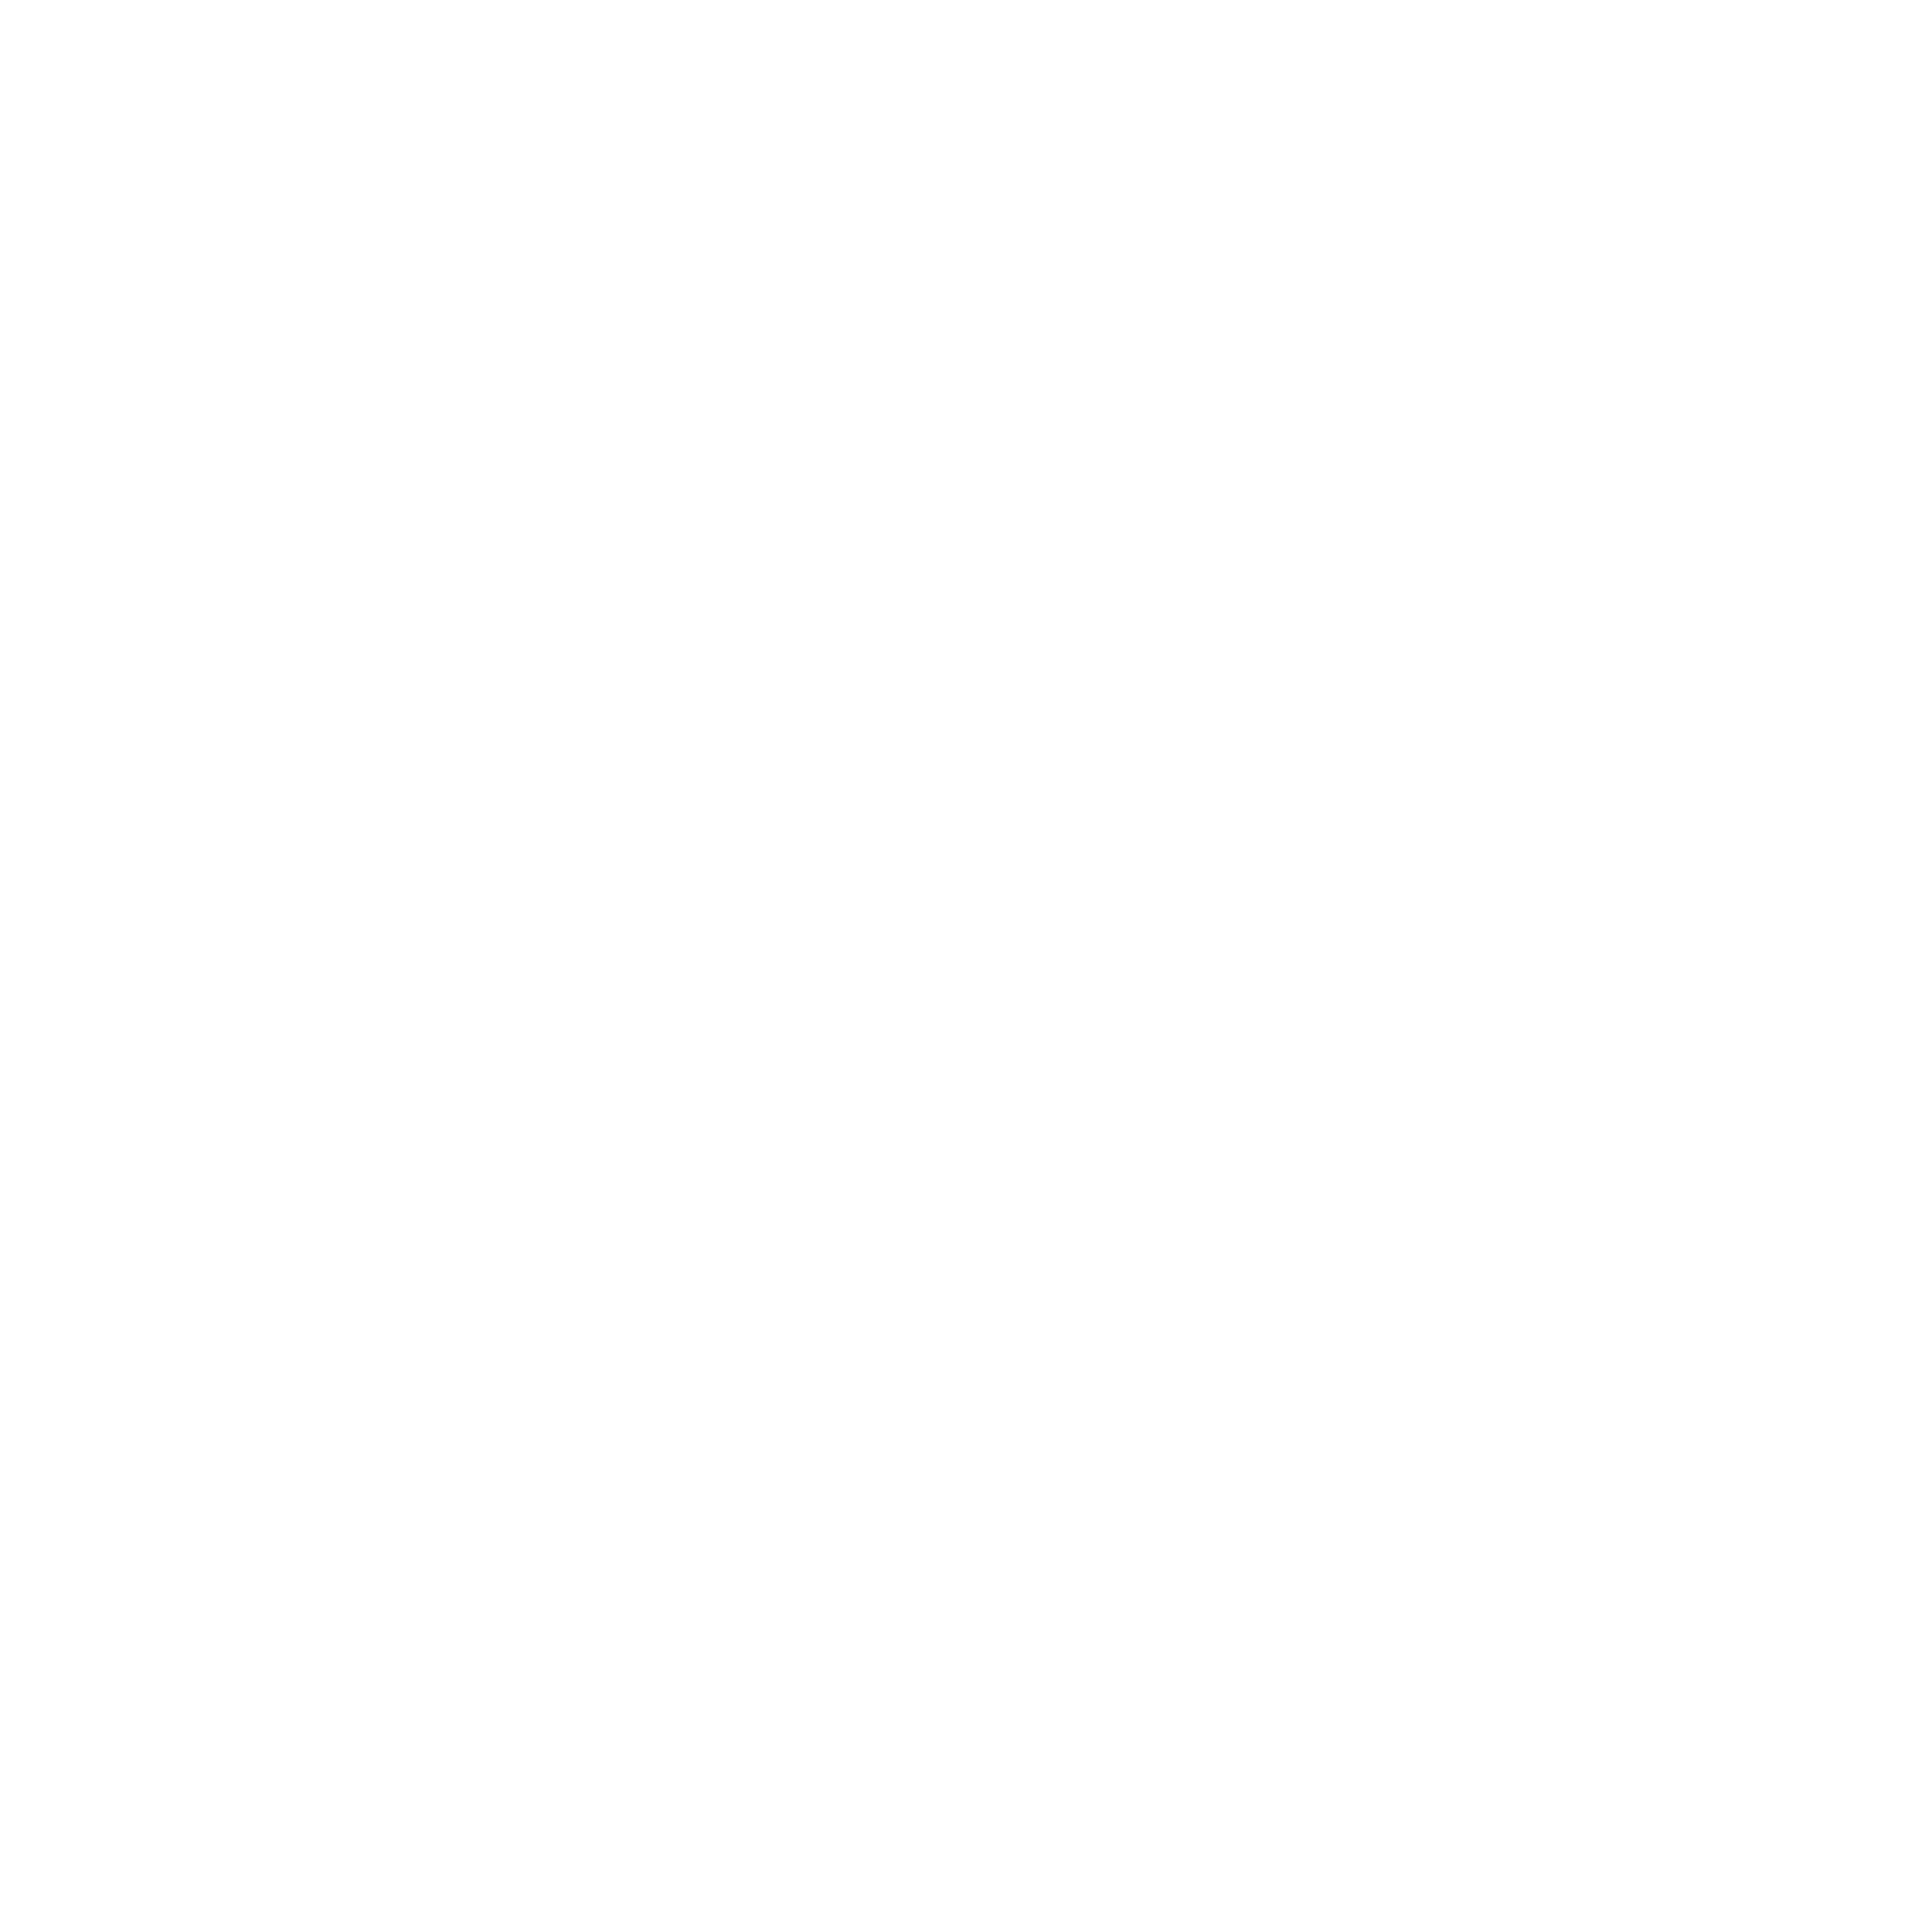

In [7]:
%matplotlib notebook

fig1 = plt.figure(figsize=(10,10))
ax1 = fig1.add_subplot()


xd_pixels = np.arange(er_ny)

lin1, = ax1.plot(xd_pixels, coadded, 'k-',label = "slice coadd")


ax1.legend(loc='best')

In [8]:
from astropy.modeling import models, fitting

background_poly = models.Polynomial1D(2)
fitter = fitting.LevMarLSQFitter()

slice_1 = coadded
slice_xpix = xd_pixels

max_pixel = np.argmax(slice_1)
fwhm = 5.

moffat_profile = models.Moffat1D(amplitude=1, gamma=fwhm, x_0=max_pixel, alpha=1)
gauss_profile = models.Gaussian1D(amplitude=1, mean=max_pixel, stddev=fwhm)

psf_gauss_template = gauss_profile  
psf_gauss_template.amplitude = slice_1[max_pixel]
psf_moff_template = moffat_profile
psf_moff_template.amplitude = slice_1[max_pixel]



moff5 = ax1.plot(slice_xpix, moffat_profile(slice_xpix), label='Moffat Profile',color='orange')
gaus5 = ax1.plot(slice_xpix, gauss_profile(slice_xpix), label='Gaussian Profile',color='green')

ax1.legend()

<IPython.core.display.Javascript object>


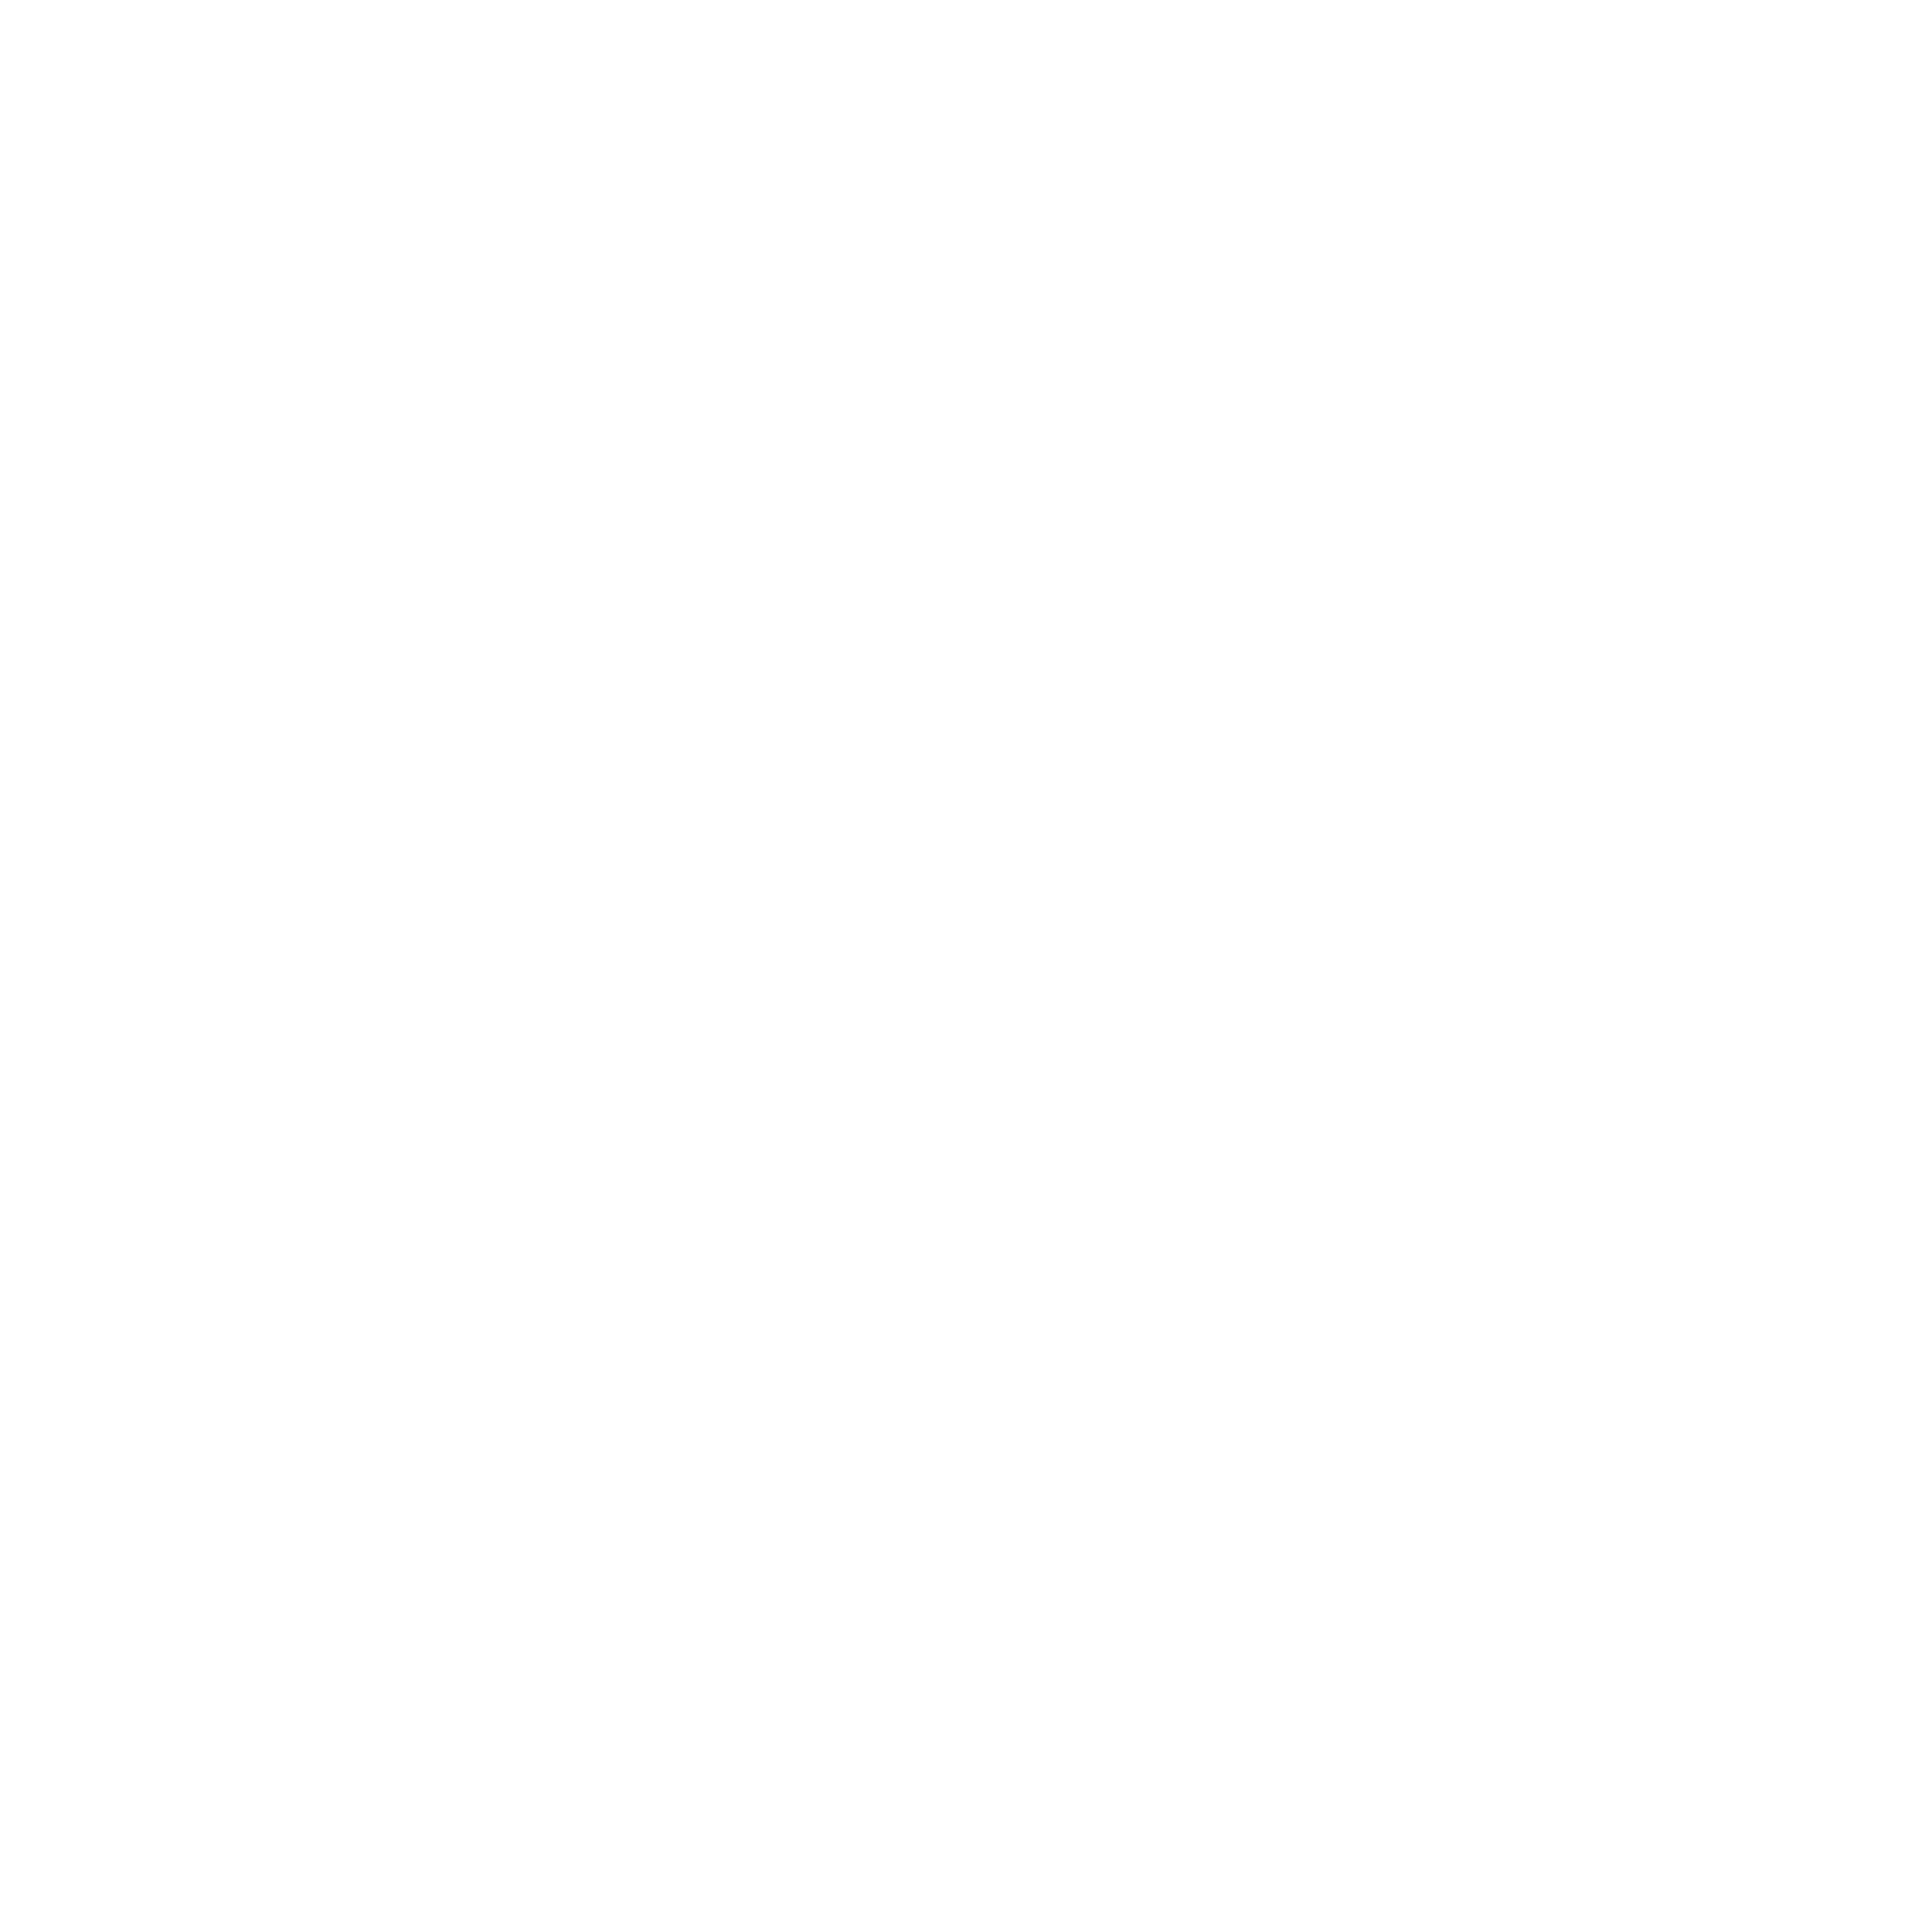

In [9]:
extraction_kernel = psf_gauss_template + background_poly
fit_extraction_kernel = fitter(extraction_kernel, slice_xpix, slice_1)
fit_line = fit_extraction_kernel(slice_xpix)

fig2 = plt.figure(figsize=(10,10))
ax2 = fig2.add_subplot()

lin1, = ax2.plot(xd_pixels, coadded, 'k-',label = "slice coadd")


psf_g = ax2.plot(slice_xpix, fit_extraction_kernel[0](slice_xpix), label="Gaussian PSF")
poly_g = ax2.plot(slice_xpix, fit_extraction_kernel[1](slice_xpix), label="Background")
sum_g = ax2.plot(slice_xpix, fit_line, label="Composite Kernel")
lgda_g = ax2.legend()


outer1, outer2 = psf_gauss_template.mean.value-psf_gauss_template.fwhm,\
            psf_gauss_template.mean.value+psf_gauss_template.fwhm


gauss_std = psf_gauss_template.stddev.value

ax2.axvline(x=psf_gauss_template.mean.value-psf_gauss_template.fwhm)
ax2.axvline(x=psf_gauss_template.mean.value+psf_gauss_template.fwhm)

ax2.axvline(x=psf_gauss_template.mean.value-2.5*gauss_std, ls='--')
ax2.axvline(x=psf_gauss_template.mean.value+2.5*gauss_std, ls='--')



In [10]:


ccd1 = CCDData(extraction_region,unit='adu',header=ccd.header)
trace_model = models.Polynomial1D(2)
fitter = fitting.LevMarLSQFitter()



sampling_step = 10
nfwhm = 1
plots = True

def trace(ccd,
          model,
          trace_model,
          model_fitter,
          sampling_step,
          nfwhm=1,
          plots=False):
    
    assert isinstance(ccd, CCDData)
    #assert isinstance(model, Model)
    #assert isinstance(trace_model, Model)

    spatial_length, dispersion_length = ccd.data.shape

    sampling_axis = range(0, dispersion_length, sampling_step)
    sample_values = []

    if model.__class__.name == 'Gaussian1D':
        model_fwhm = model.fwhm
        model_mean = model.mean.value
    elif model.__class__.name == 'Moffat1D':
        model_fwhm = model.fwhm
        model_mean = model.x_0.value
    else:
        raise NotImplementedError

    sample_center = float(model_mean)
    lower_limit_list = []
    upper_limit_list = []
    lower_limit = None
    upper_limit = None


    #sampling_axis
    for point in sampling_axis:

        lower_limit = np.max([0, int(sample_center - (nfwhm * model_fwhm))])
        upper_limit = np.min([int(sample_center + nfwhm * model_fwhm),
                                  spatial_length])

        lower_limit_list.append(lower_limit)
        upper_limit_list.append(upper_limit)

        sample = ccd.data[lower_limit:upper_limit, point:point + sampling_step]
        sample_median = np.median(sample, axis=1)
        try:
            sample_peak = np.argmax(sample_median)
        except ValueError:
            print("error:", sample_median)

        sample_values.append(sample_peak + lower_limit)

        if np.abs(sample_peak + lower_limit - model_mean)\
                < nfwhm * model_fwhm:

            sample_center = int(sample_peak + lower_limit)

        else:
            sample_center = float(model_mean)

    trace_model.c2.fixed = True


    fitted_trace = model_fitter(trace_model, sampling_axis, sample_values)

    sampling_differences = [
        (fitted_trace(sampling_axis[i]) - sample_values[i]) ** 2
        for i in range(len(sampling_axis))]

    rms_error = np.sqrt(
        np.sum(np.array(sampling_differences))/len(sampling_differences))
    
    
    
    clipped_values = sigma_clip(sampling_differences,
                                sigma=2,
                                maxiters=3,
                                cenfunc=np.ma.median)
    
    if np.ma.is_masked(clipped_values):
        _sampling_axis = list(sampling_axis)
        _sample_values = list(sample_values)

        sampling_axis = []
        sample_values = []
        for i in range(len(clipped_values)):
            if clipped_values[i] is not np.ma.masked:
                sampling_axis.append(_sampling_axis[i])
                sample_values.append(_sample_values[i])

        #log.debug("Re-fitting the trace for a better trace.")

        trace_model.c2.fixed = False

        fitted_trace = model_fitter(trace_model, sampling_axis, sample_values)

        sampling_differences = [
            (fitted_trace(sampling_axis[i]) - sample_values[i]) ** 2 for i in
            range(len(sampling_axis))]

        rms_error = np.sqrt(
            np.sum(np.array(sampling_differences)) / len(sampling_differences))

        #log.debug(
        #    "RMS Error after sigma-clipping trace differences {:.3f}".format(
        #        rms_error))

    trace_info = collections.OrderedDict()

    trace_info['GSP_TMOD'] = [fitted_trace.__class__.__name__,
                              'Model name used to fit trace']

    trace_info['GSP_TORD'] = [fitted_trace.degree,
                              'Degree of the model used to fit target trace']

    for i in range(fitted_trace.degree + 1):
        trace_info['GSP_TC{:02d}'.format(i)] = [
            fitted_trace.__getattribute__('c{:d}'.format(i)).value,
            'Parameter c{:d}'.format(i)]

    trace_info['GSP_TERR'] = [rms_error, 'RMS error of target trace']

    #log.info("Target tracing RMS error: {:.3f}".format(rms_error))

    if plots:  # pragma: no cover
        z1 = np.mean(ccd.data) - 0.5 * np.std(ccd.data)
        z2 = np.median(ccd.data) + np.std(ccd.data)
        fig, ax = plt.subplots()
        fig.canvas.set_window_title(ccd.header['GSP_FNAM'])

        mng = plt.get_current_fig_manager()
        
        #mng.window.showMaximized()

        ax.set_title("Tracing information\n{:s}\n"
                     "RMS Error {:.2f}".format(ccd.header['GSP_FNAM'],
                                               rms_error))
        ax.imshow(ccd.data, clim=(z1, z2), cmap='gray',aspect=aspect_ratio,norm=norm)
        ax.plot(sampling_axis,
                sample_values,
                color='b',
                marker='o',
                alpha=0.4,
                label='Sampling points')

        sampling_axis_limits = range(0, dispersion_length, sampling_step)

        low_span = fitted_trace(sampling_axis_limits) - (fitted_trace(sampling_axis_limits) - np.mean(lower_limit_list))
        up_span = fitted_trace(sampling_axis_limits) + (np.mean(upper_limit_list) - fitted_trace(sampling_axis_limits))

        ax.fill_between(sampling_axis_limits,
                        low_span,
                        up_span,
                        where=up_span > low_span,
                        facecolor='g',
                        interpolate=True,
                        alpha=0.3,
                        label='Aproximate extraction window')
        ax.plot(fitted_trace(range(dispersion_length)),
                color='r',
                linestyle='--',
                label='Fitted Trace Model')
        # plt.plot(model(range(spatial_length)))
        plt.tight_layout()
        ax.legend(loc='lower center',fontsize=15,bbox_to_anchor= (0.5, -20.))
        
        if plt.isinteractive():
            plt.draw()
            plt.pause(2)
        else:
            plt.show()

    return fitted_trace, trace_info, lower_limit_list, upper_limit_list




def trace_targets(ccd, target_list, sampling_step=5, pol_deg=2, nfwhm=5,
                  plots=False):
    """Find the trace of the target's spectrum on the image

    This function defines a low order polynomial that trace the location of the
    spectrum. The attributes pol_deg and sampling_step define the polynomial
    degree and the spacing in pixels for the samples. For every sample a
    gaussian model is fitted and the center (mean) is recorded and since
    spectrum traces vary smoothly this value is used as a new center for the
    base model used to fit the spectrum profile.

    Notes:
        This doesn't work for extended sources. Also this calls for the function
        `trace` for doing the actual trace, the difference is that this method
        is at a higher level.

    Args:
        ccd (CCDData) Instance of :class:`~astropy.nddata.CCDData`
        target_list (list): List of single target profiles.
        sampling_step (int): Frequency of sampling in pixels
        pol_deg (int): Polynomial degree for fitting the trace
        plots (bool): If True will show plots (debugging)
        nfwhm (int): Number of fwhm from spatial profile center to search for
        a target. default 10.

    Returns:
        all_traces (list): List that contains traces that are
            astropy.modeling.Model instance

    """

    # added two assert for debugging purposes
    assert isinstance(ccd, CCDData)
    assert all([isinstance(profile, Model) for profile in target_list])

    # Initialize model fitter
    model_fitter = fitting.LevMarLSQFitter()

    # Initialize the model to fit the traces
    trace_model = models.Polynomial1D(degree=pol_deg)

    # List that will contain all the Model instances corresponding to traced
    # targets
    all_traces = []

    for profile in target_list:

        single_trace, trace_info = trace(ccd=ccd,
                                         model=profile,
                                         trace_model=trace_model,
                                         model_fitter=model_fitter,
                                         sampling_step=sampling_step,
                                         nfwhm=nfwhm,
                                         plots=plots)

        if 0 < single_trace.c0.value < ccd.shape[0]:
            log.debug('Adding trace to list')
            all_traces.append([single_trace, profile, trace_info])
        else:
            log.error("Unable to trace target.")
            log.error('Trace is out of boundaries. Center: '
                      '{:.4f}'.format(single_trace.c0.value))

    if plots:  # pragma: no cover
        z1 = np.mean(ccd.data) - 0.5 * np.std(ccd.data)
        z2 = np.median(ccd.data) + np.std(ccd.data)
        fig, ax = plt.subplots()
        fig.canvas.set_window_title(ccd.header['GSP_FNAM'])

        mng = plt.get_current_fig_manager()
        mng.window.showMaximized()

        ax.set_title("Trace(s) for {:s}".format(ccd.header['GSP_FNAM']))
        ax.imshow(ccd.data, clim=(z1, z2), cmap='gray')
        ax.plot([], color='r', label='Trace(s)')
        for strace, prof, trace_info in all_traces:
            ax.plot(strace(range(ccd.data.shape[1])), color='r')
        ax.legend(loc='best')
        plt.tight_layout()
        plt.show()
    return all_traces



In [12]:
import PIPELINE.SpectralProcessor
#importlib.reload(PIPELINE.SpectralProcessor)



<IPython.core.display.Javascript object>


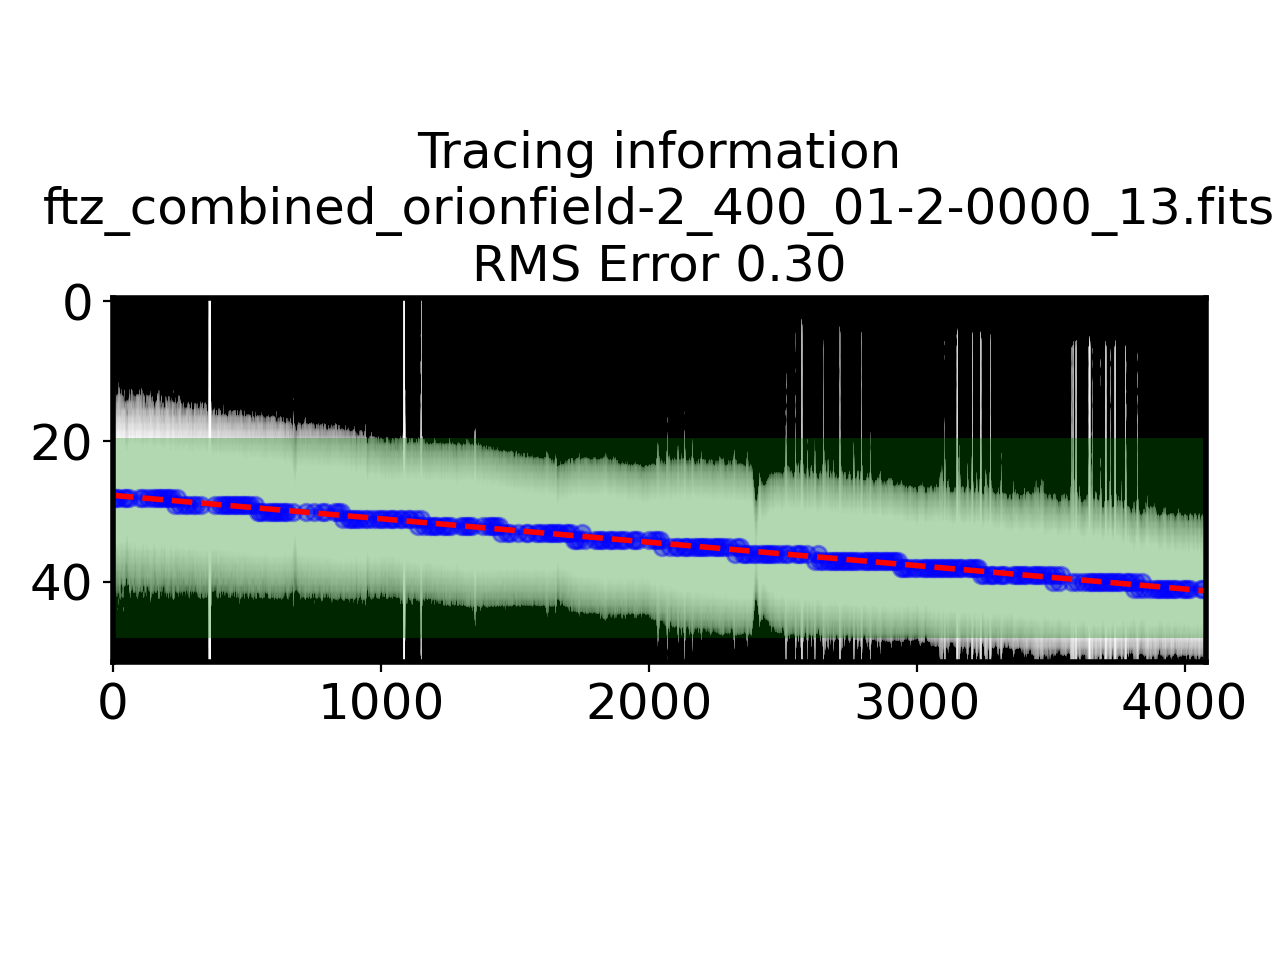

In [13]:
%matplotlib notebook

ftrace,trinf,lowlist,uplist = trace(ccd=ccd1,model=gauss_profile,model_fitter=fitter,nfwhm=1.2,plots=plots,
      sampling_step=sampling_step,trace_model=trace_model)




In [14]:
spatial_length, dispersion_length = ccd1.data.shape

sampling_axis_limits = range(0, dispersion_length, sampling_step)

low_span = ftrace(sampling_axis_limits) - 0.75*(np.mean(lowlist))
up_span = ftrace(sampling_axis_limits) + 0.35 * (np.mean(uplist))




In [15]:

col = 1
slice_width = 10
er_width = extraction_region.shape[1]
outers_1, outers_2, cols = [], [], []
spec_means = []
full_xpix = []

while col<=er_width:

    
    slice_1 = slice_coadd(col, slice_width, er_width,extraction_region)
    
    background_poly = models.Polynomial1D(2)
    fitter = fitting.LevMarLSQFitter()

    slice_xpix = slice_1.shape[0]

    max_pixel = np.argmax(slice_1)
    fwhm = 5.

    gauss_profile = models.Gaussian1D(amplitude=1, mean=max_pixel, stddev=fwhm)

    psf_gauss_template = gauss_profile  
    psf_gauss_template.amplitude = slice_1[max_pixel]
    
    std = psf_gauss_template.stddev.value
    fwhm = psf_gauss_template.fwhm
    mean = psf_gauss_template.mean.value
    
    
    outer1 = max(0,mean - 2*std)
    outer2 = min(extraction_region.shape[0]-1,mean + 2*std)
    
    outers_1.append(outer1)
    outers_2.append(outer2)
    cols.append(col)
    spec_means.append(mean)
    #print(outer1,outer2,amp)
    
    
    
    col+=slice_width
    

In [26]:
cm.cm

<module 'matplotlib.cm' from '/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cm.py'>

<IPython.core.display.Javascript object>


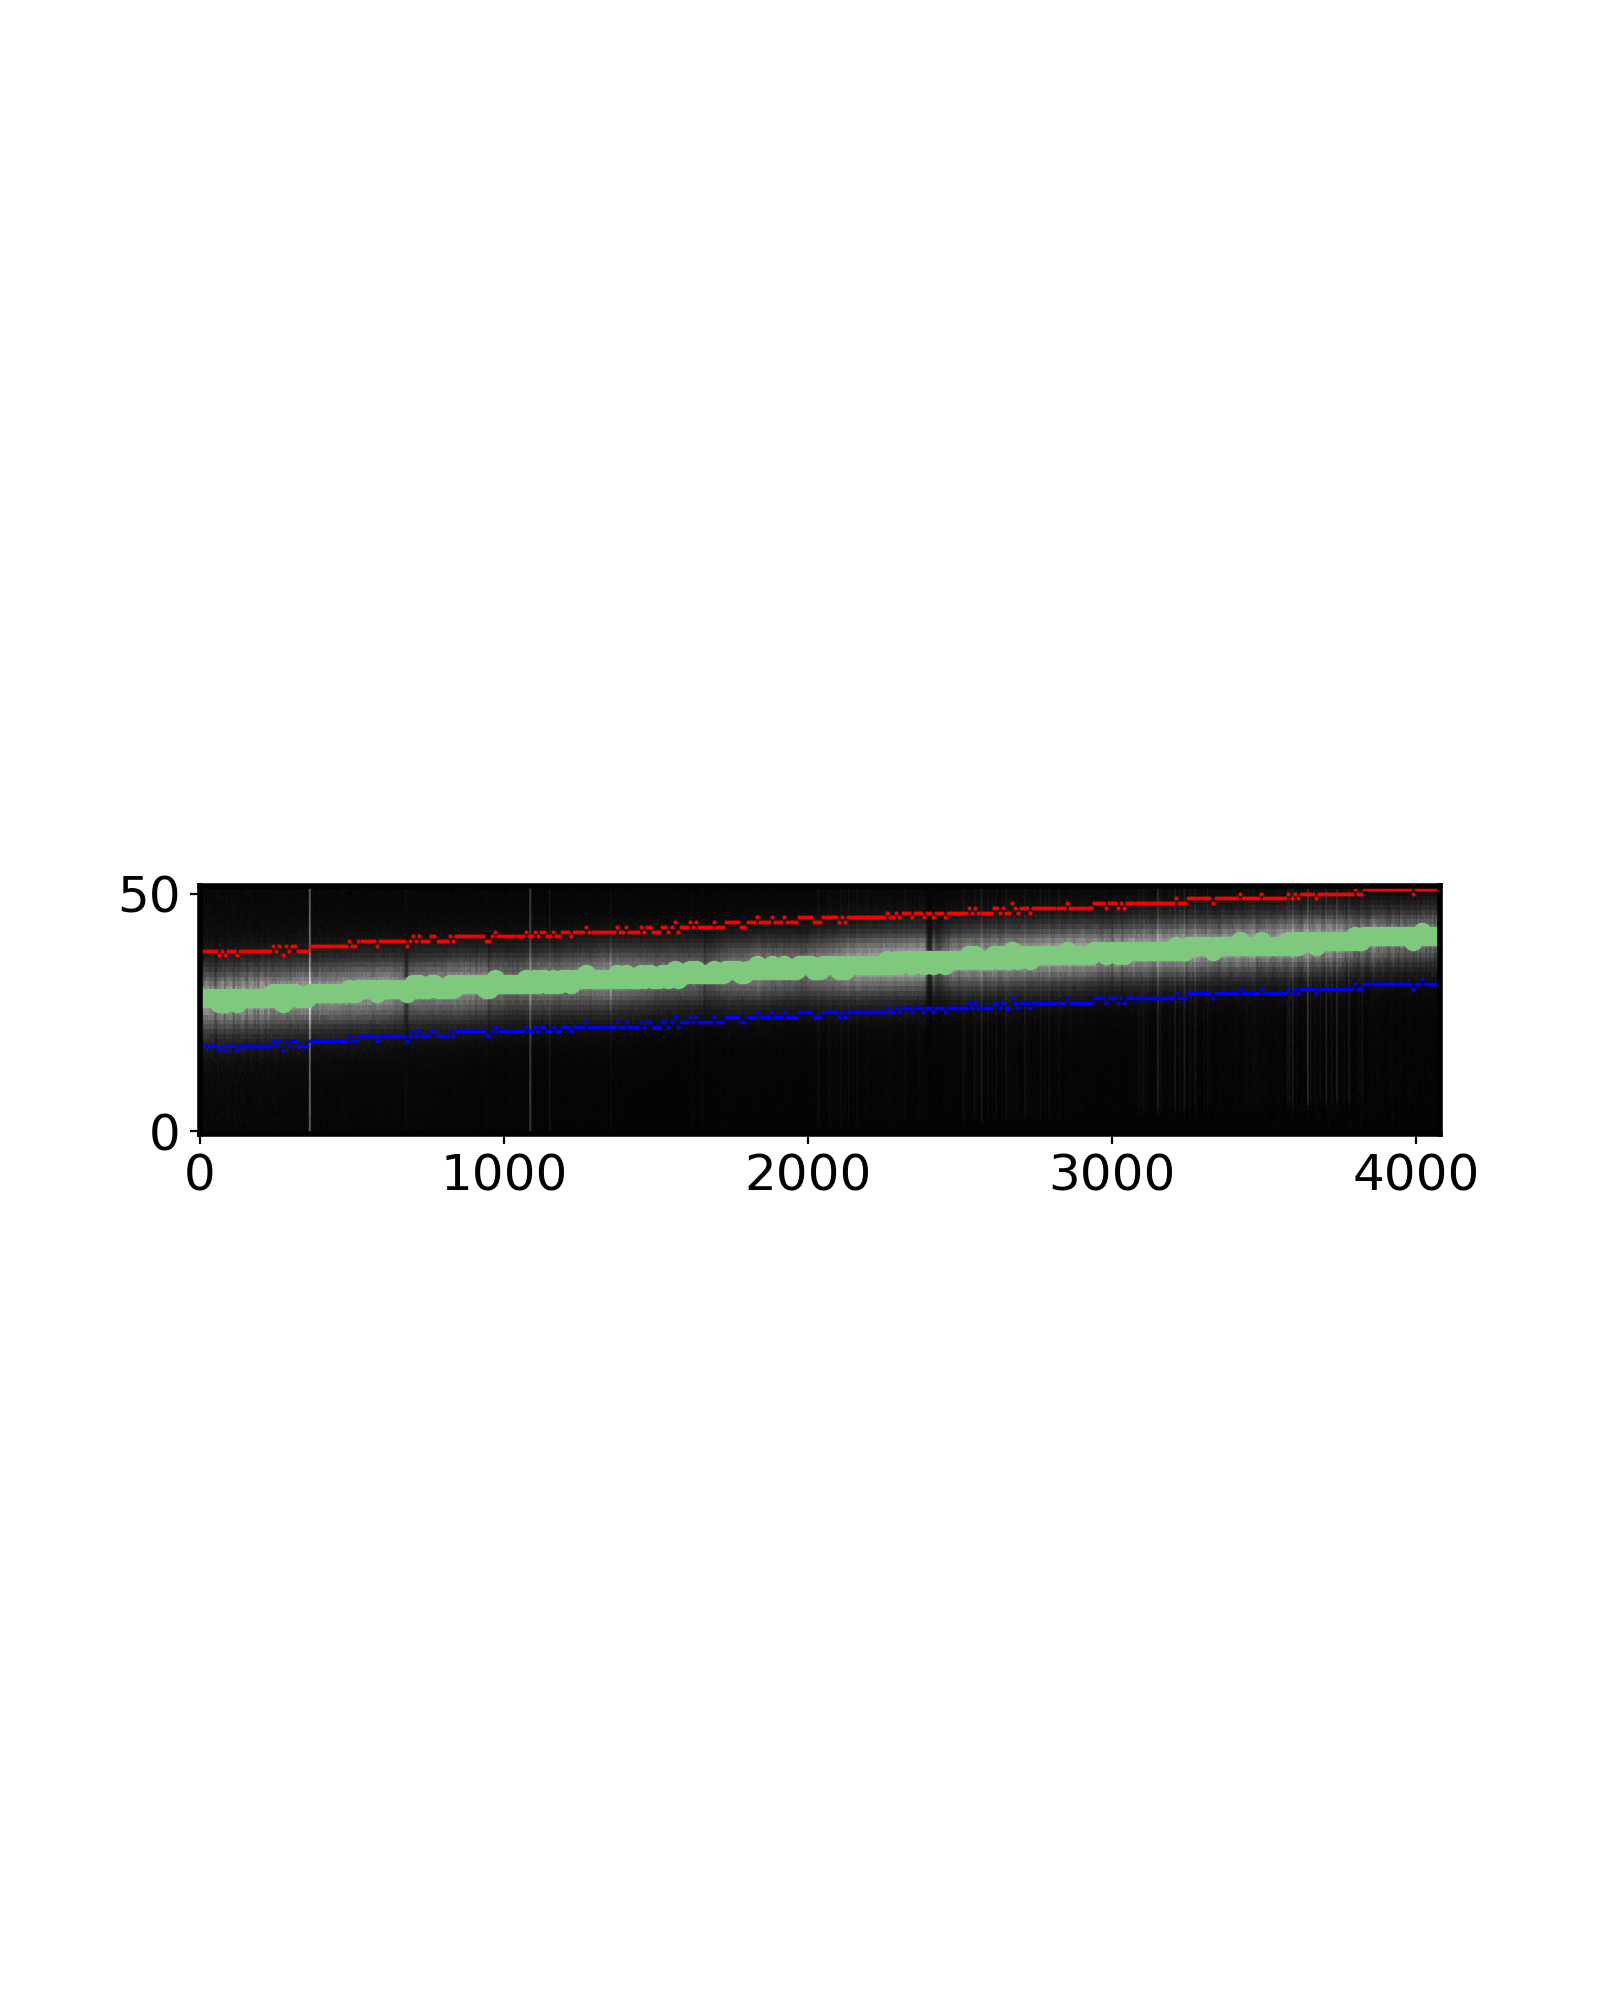

In [19]:

fig3 = plt.figure(figsize=(8,10))
ax3 = fig3.add_subplot()


ny, nx = ccd.shape
aspect_ratio = nx / (3. * ny)

ax3.imshow(extraction_region, cmap='gray', interpolation='none',origin='lower',
           norm=None,aspect=aspect_ratio)

for i in range(len(outers_1)):
    outer1 = outers_1[i]
    outer2 = outers_2[i]
    mean = spec_means[i]
    col = cols[i]
    ax3.plot(col,outer1,'.',color='blue',ms=1)
    ax3.plot(col,outer2,'.',color='red',ms=1)
    ax3.plot(col,mean,'o',color=cm.cm.Accent.colors[0])

In [51]:
p2

(array([-4.60668173e-08,  3.52505070e-03,  3.75582530e+01]),
 array([78.30280841]),
 3,
 array([1.64998035, 0.51765928, 0.09794754]),
 9.059419880941277e-14)

In [86]:
cols = np.asarray(cols)
p1 = np.polyfit(x=cols,y=outers_1,deg=1,full=True)
p2 = np.polyfit(x=cols,y=outers_2,deg=1,full=True)


polytrace1 = lambda x: p1[0][0]*x + p1[0][1] #p1[0][0]*(x**2) + p1[0][1]*x + p1[0][2]
polytrace2 = lambda x: p2[0][0]*x + p2[0][1] #p2[0][0]*(x**2) + p2[0][1]*x + p2[0][2]



y1 = polytrace1(cols)
y2 = polytrace2(cols)

yfit1 = np.polyval(p1[0],cols)
p1

(array([3.34097385e-03, 1.76806204e+01]),
 array([80.41575072]),
 2,
 array([1.3658699 , 0.36660524]),
 9.059419880941277e-14)

<IPython.core.display.Javascript object>


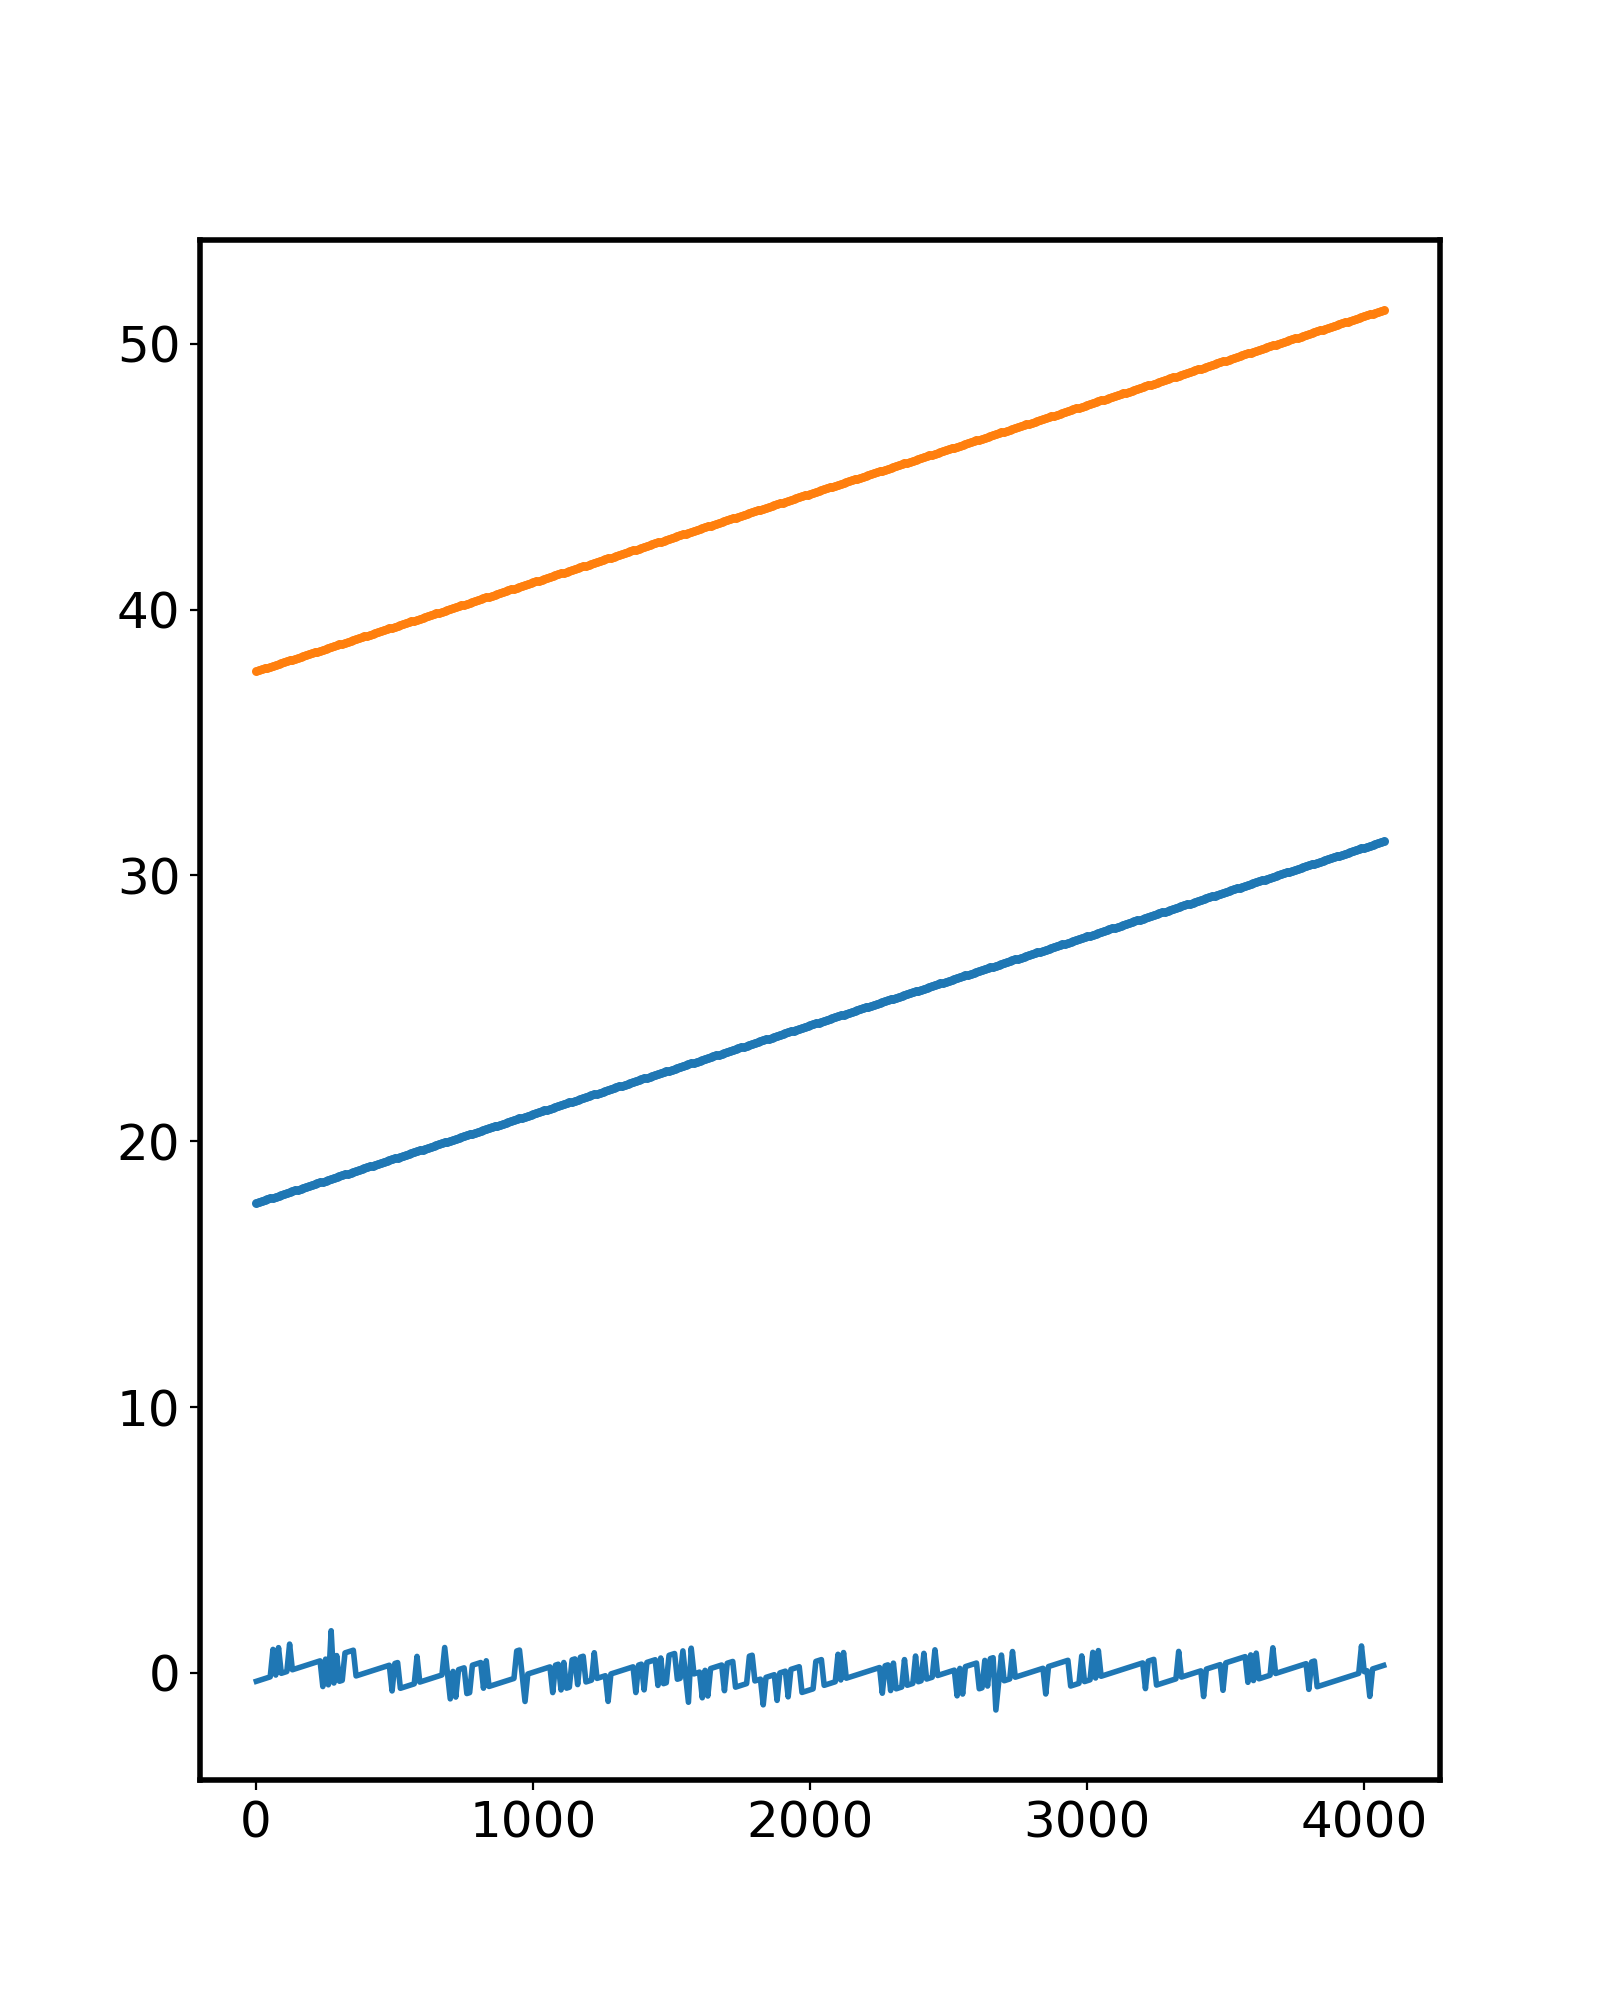

In [85]:
fig4 = plt.figure(figsize=(8,10))
ax4 = fig4.add_subplot()



ax4.scatter(x=cols,y=y1,marker='o',s=5)
ax4.scatter(x=cols,y=y2,marker='o',s=5)


#ax4.imshow(extraction_region, cmap='gray', interpolation='none',origin='lower',
#           norm=None,aspect=aspect_ratio)


ax4.plot(cols,yfit1-np.asarray(outers_1))
#ax4.axhline(y=0)